In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path='/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/ml_cleaned_deduplicated.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv(data_path)
df = df.fillna('')
df.head()


,label,tweet,clean_tweet,lemmatized_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that bummer shoulda david carr third,awww bummer shoulda david carr third
1,0,is upset that he can't update his Facebook by ...,upset that cannot update facebook texting migh...,upset update facebook texting might result sch...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest bounds,dived many time ball managed save rest bound
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving here because cannot over there,behaving


In [ ]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Apply TF-IDF transformation on the text data
tfidf_vectorizer = TfidfVectorizer()

# Fit the TF-IDF vectorizer on the entire dataset and transform the text data into a sparse matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tweet'])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, df['label'], test_size=0.20, random_state=42)



Running Fold 1/5

Fold Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      7926
           1       0.83      0.83      0.83      7926

    accuracy                           0.83     15852
   macro avg       0.83      0.83      0.83     15852
weighted avg       0.83      0.83      0.83     15852



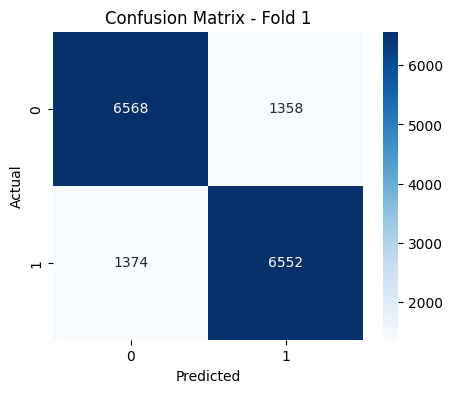


Running Fold 2/5

Fold Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      7926
           1       0.83      0.83      0.83      7926

    accuracy                           0.83     15852
   macro avg       0.83      0.83      0.83     15852
weighted avg       0.83      0.83      0.83     15852



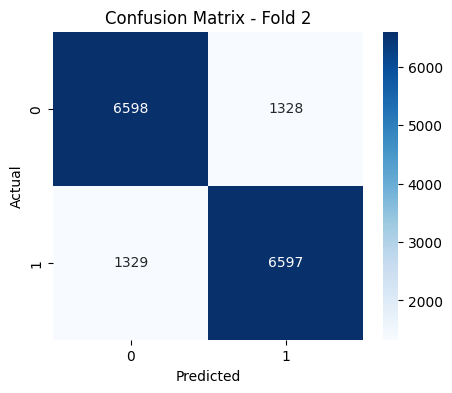


Running Fold 3/5

Fold Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      7926
           1       0.82      0.83      0.83      7926

    accuracy                           0.83     15852
   macro avg       0.83      0.83      0.83     15852
weighted avg       0.83      0.83      0.83     15852



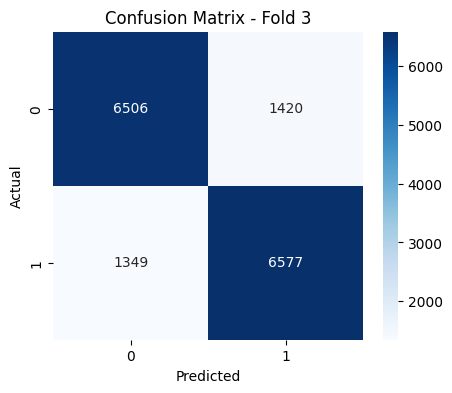


Running Fold 4/5

Fold Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      7926
           1       0.83      0.83      0.83      7926

    accuracy                           0.83     15852
   macro avg       0.83      0.83      0.83     15852
weighted avg       0.83      0.83      0.83     15852



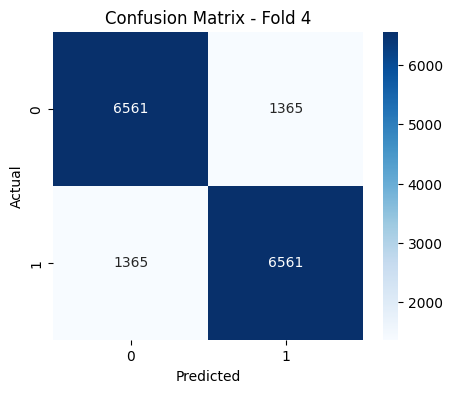


Running Fold 5/5

Fold Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      7926
           1       0.83      0.84      0.84      7926

    accuracy                           0.84     15852
   macro avg       0.84      0.84      0.84     15852
weighted avg       0.84      0.84      0.84     15852



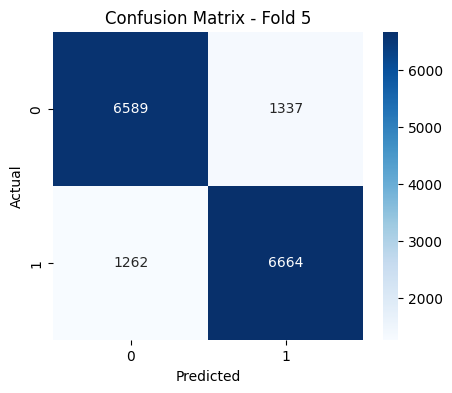


Average Cross-Validation Accuracy: 0.8298


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import json
import os
import shutil
from google.colab import drive

# Modify the run_cross_validation function to use sparse matrix indexing
def run_cross_validation(x_train, y_train, k=5):
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
        print(f"\nRunning Fold {fold + 1}/{k}")

        # Use numpy indexing to handle sparse matrix
        fold_x_train, fold_x_val = x_train[train_idx], x_train[val_idx]
        fold_y_train, fold_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the Random Forest model
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(fold_x_train, fold_y_train)

        # Evaluate the fold
        y_pred = model.predict(fold_x_val)
        acc = accuracy_score(fold_y_val, y_pred)
        fold_results.append(acc)

        # Print classification report
        print("\nFold Classification Report:")
        print(classification_report(fold_y_val, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(fold_y_val, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - Fold {fold + 1}")
        plt.show()

    print(f"\nAverage Cross-Validation Accuracy: {np.mean(fold_results):.4f}")
    return fold_results


# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Run cross-validation
cv_results = run_cross_validation(X_train, y_train, k=5)





In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the optimized parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Fewer trees for faster training
    'max_depth': [10, 20],  # Prevent deep trees
    'min_samples_split': [2, 5],  # Limit splits
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],  # Reduce features per split
    'bootstrap': [True]  # Avoid extra computations for False
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42, warm_start=True)  # Enable warm_start

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=30,  # Try only 30 random combinations instead of 324
    cv=3,  # Reduce folds to 3
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

# Fit the search
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_rf_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best Cross-Validation Score: 0.7556396669190008


Test Accuracy: 0.76

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      9908
           1       0.75      0.79      0.77      9908

    accuracy                           0.76     19816
   macro avg       0.76      0.76      0.76     19816
weighted avg       0.76      0.76      0.76     19816



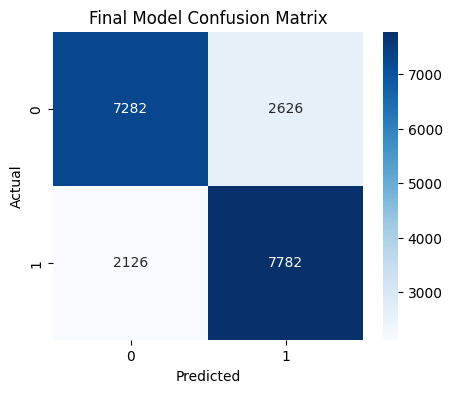

In [ ]:
# Evaluate the model on the test set
accuracy = best_rf_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Final model evaluation on test set
y_pred_test = best_rf_model.predict(X_test)

# Print classification report
print("\nFinal Model Classification Report:")
print(classification_report(y_test, y_pred_test))

# Plot final confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Model Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Retrieve the best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_rf_model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Test Set Accuracy: 0.7602

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      9908
           1       0.75      0.79      0.77      9908

    accuracy                           0.76     19816
   macro avg       0.76      0.76      0.76     19816
weighted avg       0.76      0.76      0.76     19816


Confusion Matrix:
[[7282 2626]
 [2126 7782]]


In [ ]:
import os
import pickle
import json
import shutil
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix

def save_model_to_drive(model, vectorizer, model_name, metrics=None):
    # Mount Google Drive
    drive.mount("/content/drive", force_remount=True)

    # Paths
    local_path = f"./{model_name}"
    drive_base_path = "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/Random Forest"
    drive_path = os.path.join(drive_base_path, model_name)

    # Create local directory if it doesn't exist
    if not os.path.exists(local_path):
        os.makedirs(local_path)

    # Save model and vectorizer locally
    model_filename = os.path.join(local_path, "model.pkl")
    vectorizer_filename = os.path.join(local_path, "vectorizer.pkl")

    with open(model_filename, "wb") as model_file:
        pickle.dump(model, model_file)
    with open(vectorizer_filename, "wb") as vectorizer_file:
        pickle.dump(vectorizer, vectorizer_file)

    # Save metrics as JSON file
    if metrics:
        with open(os.path.join(local_path, "metrics.json"), "w") as f:
            json.dump(metrics, f, indent=4)

    # Remove old copy in Google Drive (if exists)
    if os.path.exists(drive_path):
        shutil.rmtree(drive_path)

    # Copy files to Google Drive
    shutil.copytree(local_path, drive_path)
    print(f"Model and metrics saved to Google Drive at: {drive_path}")

# Example metrics for Random Forest
accuracy_rf = best_rf_model.score(X_test, y_test)  # Accuracy on the test set
accuracy_cv_rf = np.mean(cv_results)  # Cross-validation accuracy

# Predictions and classification report
y_pred_rf = best_rf_model.predict(X_test)

metrics_rf = {
    "accuracy": accuracy_rf,
    "cross_val_accuracy": accuracy_cv_rf,
    "classification_report": classification_report(y_test, y_pred_rf, output_dict=True),
    "confusion_matrix": confusion_matrix(y_test, y_pred_rf).tolist()
}

# Save Random Forest model and metrics
save_model_to_drive(best_rf_model, tfidf_vectorizer, "Random_Forest_Model", metrics=metrics_rf)


Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/it1244 girl boss/IT1244_Team1_Project/Model & Dataset/Random Forest/Random_Forest_Model


Cleaned but without removing duplicates [run the code as a whole since variable names have been repeated]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path='/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/ml_cleaned.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df_clean = pd.read_csv(data_path)
df_clean = df_clean.fillna('')
df_clean.head()

,label,tweet,clean_tweet,lemmatized_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that bummer shoulda david carr third,awww bummer shoulda david carr third
1,0,is upset that he can't update his Facebook by ...,upset that cannot update facebook texting migh...,upset update facebook texting might result sch...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest bounds,dived many time ball managed save rest bound
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving here because cannot over there,behaving


In [ ]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF transformation on the text data
tfidf_vectorizer = TfidfVectorizer()

# Fit the TF-IDF vectorizer on the entire dataset and transform the text data into a sparse matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['tweet'])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, df_clean['label'], test_size=0.20, random_state=42)



Running Fold 1/5

Fold Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      8000
           1       0.76      0.77      0.77      8000

    accuracy                           0.76     16000
   macro avg       0.76      0.76      0.76     16000
weighted avg       0.76      0.76      0.76     16000



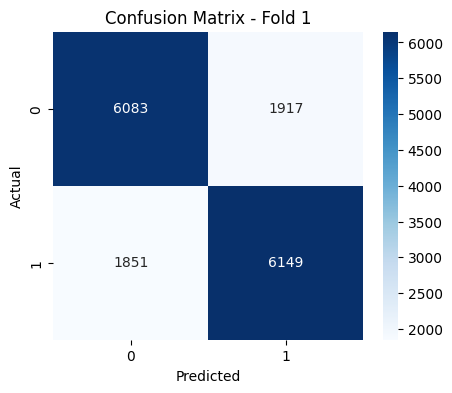


Running Fold 2/5

Fold Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      8000
           1       0.77      0.77      0.77      8000

    accuracy                           0.77     16000
   macro avg       0.77      0.77      0.77     16000
weighted avg       0.77      0.77      0.77     16000



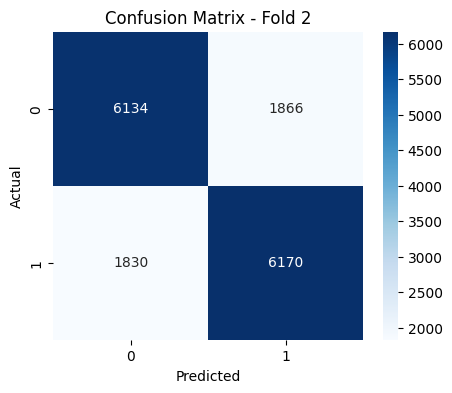


Running Fold 3/5

Fold Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      8000
           1       0.77      0.77      0.77      8000

    accuracy                           0.77     16000
   macro avg       0.77      0.77      0.77     16000
weighted avg       0.77      0.77      0.77     16000



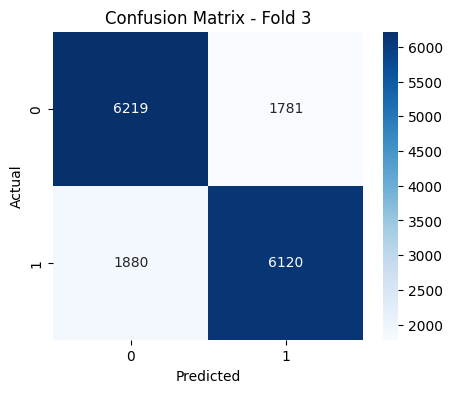


Running Fold 4/5

Fold Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      8000
           1       0.76      0.77      0.77      8000

    accuracy                           0.76     16000
   macro avg       0.76      0.76      0.76     16000
weighted avg       0.76      0.76      0.76     16000



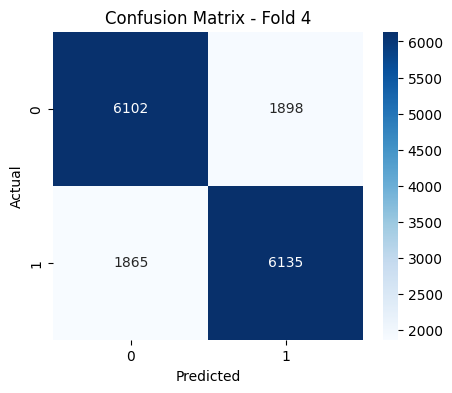


Running Fold 5/5

Fold Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      8000
           1       0.77      0.76      0.76      8000

    accuracy                           0.76     16000
   macro avg       0.76      0.76      0.76     16000
weighted avg       0.76      0.76      0.76     16000



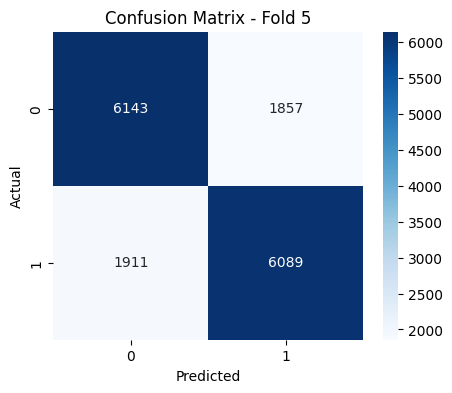


Average Cross-Validation Accuracy: 0.7668


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pickle
import json
import os
import shutil
from google.colab import drive

# Modify the run_cross_validation function to use sparse matrix indexing
def run_cross_validation(x_train, y_train, k=5):
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
        print(f"\nRunning Fold {fold + 1}/{k}")

        # Use numpy indexing to handle sparse matrix
        fold_x_train, fold_x_val = x_train[train_idx], x_train[val_idx]
        fold_y_train, fold_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the Random Forest model
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(fold_x_train, fold_y_train)

        # Evaluate the fold
        y_pred = model.predict(fold_x_val)
        acc = accuracy_score(fold_y_val, y_pred)
        fold_results.append(acc)

        # Print classification report
        print("\nFold Classification Report:")
        print(classification_report(fold_y_val, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(fold_y_val, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - Fold {fold + 1}")
        plt.show()

    print(f"\nAverage Cross-Validation Accuracy: {np.mean(fold_results):.4f}")
    return fold_results


# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df_clean['label'], test_size=0.2, random_state=42, stratify=df_clean['label'])

# Run cross-validation
cv_results = run_cross_validation(X_train, y_train, k=5)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the optimized parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Fewer trees for faster training
    'max_depth': [10, 20],  # Prevent deep trees
    'min_samples_split': [2, 5],  # Limit splits
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],  # Reduce features per split
    'bootstrap': [True]  # Avoid extra computations for False
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42, warm_start=True)  # Enable warm_start

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=30,  # Try only 30 random combinations instead of 324
    cv=3,  # Reduce folds to 3
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

# Fit the search
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_rf_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best Cross-Validation Score: 0.7449875305456904


Test Accuracy: 0.74

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74     10000
           1       0.74      0.76      0.75     10000

    accuracy                           0.74     20000
   macro avg       0.75      0.74      0.74     20000
weighted avg       0.75      0.74      0.74     20000



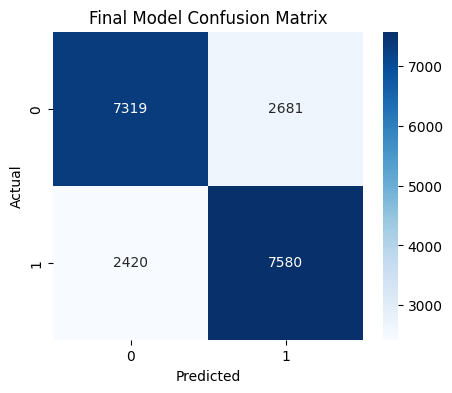

In [ ]:
# Evaluate the model on the test set
accuracy = best_rf_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Final model evaluation on test set
y_pred_test = best_rf_model.predict(X_test)

# Print classification report
print("\nFinal Model Classification Report:")
print(classification_report(y_test, y_pred_test))

# Plot final confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Model Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Retrieve the best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_rf_model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Set Accuracy: 0.7450

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74     10000
           1       0.74      0.76      0.75     10000

    accuracy                           0.74     20000
   macro avg       0.75      0.74      0.74     20000
weighted avg       0.75      0.74      0.74     20000


Confusion Matrix:
[[7319 2681]
 [2420 7580]]


In [ ]:
import os
import pickle
import json
import shutil
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix

def save_model_to_drive(model, vectorizer, model_name, metrics=None):
    # Mount Google Drive
    drive.mount("/content/drive", force_remount=True)

    # Paths
    local_path = f"./{model_name}"
    drive_base_path = "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/Random Forest"
    drive_path = os.path.join(drive_base_path, model_name)

    # Create local directory if it doesn't exist
    if not os.path.exists(local_path):
        os.makedirs(local_path)

    # Save model and vectorizer locally
    model_filename = os.path.join(local_path, "model_cleaned_notdeduplicated.pkl")
    vectorizer_filename = os.path.join(local_path, "vectorizer_cleaned_notdeduplicated.pkl")

    with open(model_filename, "wb") as model_file:
        pickle.dump(model, model_file)
    with open(vectorizer_filename, "wb") as vectorizer_file:
        pickle.dump(vectorizer, vectorizer_file)

    # Save metrics as JSON file
    if metrics:
        with open(os.path.join(local_path, "metrics_cleaned_notdeduplicated.json"), "w") as f:
            json.dump(metrics, f, indent=4)

    # Remove old copy in Google Drive (if exists)
    if os.path.exists(drive_path):
        shutil.rmtree(drive_path)

    # Copy files to Google Drive
    shutil.copytree(local_path, drive_path)
    print(f"Model and metrics saved to Google Drive at: {drive_path}")

# Example metrics for Random Forest
accuracy_rf = best_rf_model.score(X_test, y_test)  # Accuracy on the test set
accuracy_cv_rf = np.mean(cv_results)  # Cross-validation accuracy

# Predictions and classification report
y_pred_rf = best_rf_model.predict(X_test)

metrics_rf = {
    "accuracy": accuracy_rf,
    "cross_val_accuracy": accuracy_cv_rf,
    "classification_report": classification_report(y_test, y_pred_rf, output_dict=True),
    "confusion_matrix": confusion_matrix(y_test, y_pred_rf).tolist()
}

# Save Random Forest model and metrics
save_model_to_drive(best_rf_model, tfidf_vectorizer, "Random_Forest_Model", metrics=metrics_rf)

Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/it1244 girl boss/IT1244_Team1_Project/Model & Dataset/Random Forest/Random_Forest_Model
